Use the [AFSC's lcWGS analysis pipeline](https://github.com/AFSC-Genetics/lcWGS-pipeline/tree/main) to analyze lcWGS data from juvenile Pacific cod which were experimentally exposed to varying temperatures. The purpose of this data/analysis is to

  1) identify from which population(s) the juvenile cod came,   
  2) characterize parentage/sibship to help select samples for other analyses (RNASeq, methylation, and lipid analyses).  

NOTE: because only a couple fish died during the experiment, this analysis will NOT assess genetic composition differences among treatments (i.e. no selection could occur during experiment) 

### Get data. 

The Roberts Lab archived the data on their Nightengales server. I copied it to the directory **/share/afsc/pcod-lcwgs-2023/raw-data** on Sedna using 
`wget -r -np --no-check-certificate -P raw-data/ https://owl.fish.washington.edu/nightingales/G_macrocephalus/H202SC23041287/01.RawData/`

Since I copied the files over via wget (not rsync) I need to make sure they transferred correctly by comparing checksums. 

```
IN=/share/afsc/pcod-lcwgs-2023/raw-data
FOLDERS=$(ls -1d ${IN}/G* | awk -F "/" '{ print $NF }')
for folder in $FOLDERS
do
cd /share/afsc/pcod-lcwgs-2023/raw-data/${folder}
md5sum --check MD5.txt
done
```

The raw-data/ directory contains separate subdirectories for each sample, each containing 2 or 4 gzipped fastq files (.fq.gz). Here are all subdirectories, which are named after sample IDs: 

```
(base) [lspencer@node01 raw-data]$ ls
 GM1     GM13    GM19   GM5    GM80
 GM10    GM130   GM2    GM50   GM81
 GM100   GM131   GM20   GM51   GM82
 GM101   GM132   GM21   GM52   GM83
 GM102   GM133   GM22   GM53   GM84
 GM103   GM134   GM23   GM54   GM85
 GM104   GM135   GM24   GM55   GM86
 GM105   GM136   GM25   GM56   GM87
 GM106   GM137   GM26   GM57   GM88
 GM107   GM138   GM27   GM58   GM89
 GM108   GM139   GM28   GM59   GM9
 GM109   GM14    GM29   GM6    GM90
 GM11    GM140   GM3    GM60   GM91
 GM110   GM141   GM30   GM61   GM92
 GM111   GM142   GM31   GM62   GM93
 GM112   GM143   GM32   GM63   GM94
 GM113   GM144   GM33   GM64   GM95
 GM114   GM145   GM34   GM65   GM96
 GM115   GM146   GM35   GM66   GM97
 GM116   GM147   GM36   GM67   GM98
 GM117   GM148   GM37   GM68   GM99
 GM118   GM149   GM38   GM69   index.html
 GM119   GM15    GM39   GM7   'index.html?C=D;O=A'
 GM12    GM150   GM4    GM70  'index.html?C=D;O=D'
 GM120   GM151   GM40   GM71  'index.html?C=M;O=A'
 GM121   GM152   GM41   GM72  'index.html?C=M;O=D'
 GM122   GM153   GM42   GM73  'index.html?C=N;O=A'
 GM123   GM154   GM43   GM74  'index.html?C=N;O=D'
 GM124   GM155   GM44   GM75  'index.html?C=S;O=A'
 GM125   GM156   GM45   GM76  'index.html?C=S;O=D'
 GM126   GM16    GM46   GM77
 GM127   GM160   GM47   GM78
 GM128   GM17    GM48   GM79
 GM129   GM18    GM49   GM8
```

Here are the contents of a couple sample subdirectories:
```
(base) [lspencer@node01 raw-data]$ ls GM10/
 GM10_CKDN230011848-1A_H5NNGDSX7_L1_1.fq.gz
 GM10_CKDN230011848-1A_H5NNGDSX7_L1_2.fq.gz
 index.html
'index.html?C=D;O=A'
'index.html?C=D;O=D'
'index.html?C=M;O=A'
'index.html?C=M;O=D'
'index.html?C=N;O=A'
'index.html?C=N;O=D'
'index.html?C=S;O=A'
'index.html?C=S;O=D'
 MD5.txt
(base) [lspencer@node01 raw-data]$ ls GM1/
 GM1_CKDN230011839-1A_H5NNGDSX7_L1_1.fq.gz
 GM1_CKDN230011839-1A_H5NNGDSX7_L1_2.fq.gz
 GM1_CKDN230011839-1A_H733MDSX7_L1_1.fq.gz
 GM1_CKDN230011839-1A_H733MDSX7_L1_2.fq.gz
 index.html
'index.html?C=D;O=A'
'index.html?C=D;O=D'
'index.html?C=M;O=A'
'index.html?C=M;O=D'
'index.html?C=N;O=A'
'index.html?C=N;O=D'
'index.html?C=S;O=A'
'index.html?C=S;O=D'
 MD5.txt
```

### Concatenate by sample

The data is paired-end, R1 and R2 for each sample, but some of the samples also have two files for each R1 and R2 (e.g. see files for "GM1" above). So, I need to concatenate before running my pipeline. I'll also rename the files to only include sample ID. Code for concatenating is saved in the script [concat_fastq_files.sh](), but I ran it interactively on Sedna so will paste it here too. The result if this code is two files for each sample named "GM{ID}\_R{1,2}.fastq", one for each read, saved in the directory /share/afsc/pcod-lcwgs-2023/concat.

```
IN=/share/afsc/pcod-lcwgs-2023/raw-data
OUT=/home/lspencer/pcod-lcwgs-2023/analysis-20230828

SAMPLES=$(ls -1d ${IN}/G* | awk -F "/" '{ print $NF }')

for sample in ${SAMPLES}
do
  echo ${sample}
  zcat ${sample}/${sample}_*_L*_1.fq.gz \
      >> ${OUT}/${sample}_R1.fastq
  zcat ${sample}/${sample}_*_L*_2.fq.gz \
      >> ${OUT}/${sample}_R2.fastq
done
```

### Prepare input files for lcWGS pipeline

First I cloned lcWGS github to Sedna using `git clone https://github.com/AFSC-Genetics/lcWGS-pipeline.git`, which downloaded the [lcWGS-pipeline repo](https://github.com/AFSC-Genetics/lcWGS-pipeline/tree/main) to Sedna in /home/lspencer/. I then prepared input files: 
- **lcWGS_config.txt** - created on my pers. computer and transferred to Sedna. Here is what it contains: 

```
# Remember to provide the full paths to files and directories.
#The reference genome MUST be a fasta with the ".fa" file extension.
#The working directory should contain the list of fastq files and the gzipped fastq files.
# Don't worry about adding modules yourself. The pipeline will check for all needed modules and add them if they are not found.
# If you run into trouble, please contact Laura.Timm@noaa.gov

What file contains the list of FASTQs that will go into the analysis?   /home/lspencer/pcod-lcwgs-2023/analysis-20230828/pcod-lcWGS_fastqs.txt
What file contains adapter sequences for TRIMMOMATIC?   /home/lspencer/pcod-lcwgs-2023/analysis-20230828/novogene-adapters.txt
What chromosomes/contigs are to be analyzed in this run?        /home/lspencer/pcod-lcwgs-2023/analysis-20230828/chromosomes.txt
What is the name of the FASTA file containing the reference genome?     /home/lspencer/references/pcod/PGA_assembly_hap2.chrom_only.fa
What is the path to the working directory?      /home/lspencer/pcod-lcwgs-2023/analysis-20230828/
What prefix would you like associated with this run?    pcod-lcWGS
Where should failed job notifications be sent?  laura.spencer@noaa.gov
```

- **Pipeline Python and R scripts** - all saved in the lcWGS-pipeline repo and made executable via `chmod u+x {filename}`. NOTE: I did not add all scripts to my bin. Instead I will run them using their full path.    
- **P. cod reference genome, I'm using PGA_assembly_hap2.chrom_only.fa** - Ingrid sent to me via email, and downloaded to my pers. computer then copied to /home/lspencer/references/pcod/, and renamed to change from ".fasta" to ".fa" (as specificed by the pipeline README file).  
- **chromosomes.txt** - list of chromosomes in P. cod genome, created via `grep ">" ../references/pcod/PGA_assembly_hap2.chrom_only.fa | tr -d '>' >> chromosome.txt`  
- **pcod-lcWGS_fastqs.txt**, a list of .fq files - I created this by moving to the directory with concatenated data (/home/lspencer/pcod-lcwgs-2023/concat) and running ```ls *.fastq | while read file; do newfile=`echo /home/lspencer/pcod-lcwgs-2023/analysis-20230828/$file`; echo $newfile >> /home/lspencer/pcod-lcwgs-2023/analysis-20230828/pcod-lcWGS_fastqs.txt; done```

Do these for each session: 
- Activate virtual environment to access MultiQC via `source /home/lspencer/venv/bin/activate`
- Define path variables: 
```
scripts=/home/lspencer/lcWGS-pipeline/  
inputs=/home/lspencer/pcod-lcwgs-2023/analysis-20230828/
```

Now I am ready to run the scripts. 

### Run Steps 0-3 to generate SLURM scripts 

#### Step0: Configure
```
(venv) (base) [lspencer@node01 analysis-20230828]$ ${scripts}lcWGSpipeline_step0-configure.py -c ${inputs}lcWGS_config.txt
Step 0 has finished successfully! You will find two new scripts in ./scripts/: /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/PGA_assembly_hap2.chrom_only_bwa-indexSLURM.sh and /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/PGA_assembly_hap2.chrom_only_faiSLURM.sh.
Both scripts can run simultaneously with 'sbatch'.
 However, there is no need to wait for these jobs to finish to move to step 1.
To continue on, call step 1 to generate scripts for fastQC and multiQC.
Remember to pass the newly-made checkpoint (.ckpt) file with the '-p' flag.
```

#### Step1: QC
```
(venv) (base) [lspencer@node01 analysis-20230828]$ ${scripts}lcWGSpipeline_step1-qc.py -p pcod-lcWGS.ckpt
Step 1 has finished successfully! You will find two new scripts in ./scripts/: /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-raw_fastqcARRAY.sh and /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-raw_multiqcSLURM.sh.
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-raw_fastqcARRAY.sh must run prior to launching /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-raw_multiqcSLURM.sh.
 However, there is no need to wait for these jobs to finish to move to step 2.
To continue on, call step 2 to generate a script for TRIMMOMATIC.
Remember to pass the checkpoint (.ckpt) file with the '-p' flag.
```

#### Step2: Trim
```
(venv) (base) [lspencer@node01 analysis-20230828]$ ${scripts}lcWGSpipeline_step2-trim.py -p pcod-lcWGS.ckpt
Step 2 has finished successfully! You will find three new scripts in ./scripts/: /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_trimARRAY.sh, /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-trim_fastqcARRAY.sh, and /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS-trim_multiqcSLURM.sh.
Each script must run in the above order and each job must finish before submitting the next.
While there is no need to wait before running step 3 to generate the alignment script, it is probably wise to wait until the multiQC script has completed and the results have been viewed in a web browser prior to submitting the script written by step 3.
Remember to pass the checkpoint (.ckpt) file with the '-p' flag.
```

#### Step3: Align

```
(base) [lspencer@sedna analysis-20230828]$ /home/lspencer/lcWGS-pipeline/lcWGSpipeline_step3-align.py -p pcod-lcWGS.ckpt
Step 3 has finished successfully! You will find two new scripts in ./scripts/: /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_alignARRAY.sh and /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_depthsARRAY.sh.
These scripts must be run in the order given above and both must finish before moving on to step 4.
After /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_depthsARRAY.sh has run, download the resulting file: pcod-lcWGS_depths.csv and generate a barchart of mean depths by individual. This will help you determine whether any individuals fall substantially below the average depth (usually, we use a cutoff of 1x).
If you identify samples with coverage that is 'too low', add the sample id(s) to a new file, referred to as the 'blacklist' of individuals to be excluded from genotype likelhiood calculations and the final data sets.
After generating this blacklist, you can continue to step 4 to write scripts for generating the final data sets.
Remember to pass the checkpoint (.ckpt) file with the '-p' flag AND the blacklist file with the '-b' flag.
```

### Run SLURM scripts from steps 0-3. 

As per instructions, edited the MultiQC scripts (for raw and trimmed data) using nano to use the correct path to activate my virtual environment (/home/lspencer/venv/bin/activate)

Ran these three scripts immediately  
`sbatch scripts/PGA_assembly_hap2.chrom_only_bwa-indexSLURM.sh`  
`sbatch scripts/PGA_assembly_hap2.chrom_only_faiSLURM.sh`  
`sbatch scripts/pcod-lcWGS-raw_fastqcARRAY.sh`  

Then this one to run multiqc - `sbatch scripts/pcod-lcWGS-raw_multiqcSLURM.sh` - After it finished I transferred the multiqc files to my local computer to view and renamed to "_raw". Raw data looks good! 

Then ran these scripts, one after the other:  
`sbatch scripts/pcod-lcWGS_trimARRAY.sh`  
`sbatch scripts/pcod-lcWGS-trim_fastqcARRAY.sh`  
`sbatch scripts/pcod-lcWGS-trim_multiqcSLURM.sh`  

Transferred the multiqc files to my local computer, renamed to "_trimmed". Looks good!

Ran the alignment scripts one after the other:   
`sbatch pcod-lcWGS_alignARRAY.sh`   
`sbatch scripts/pcod-lcWGS_depthsARRAY.sh` - I had to modify this script to include the full path for the python script `/home/lspencer/lcWGS-pipeline/mean_cov_ind.py.`

This barplot shows the mean coverage depth for each sample (sorted by depth), color coded by temperature treatment. The lcWGS pipeline states that samples with mean depth <1 should be blacklisted. All samples look good! Interesting that samples with lowest mean coverage are from warmer treatments, and those with highest mean coverage are from the 5C treatment. 

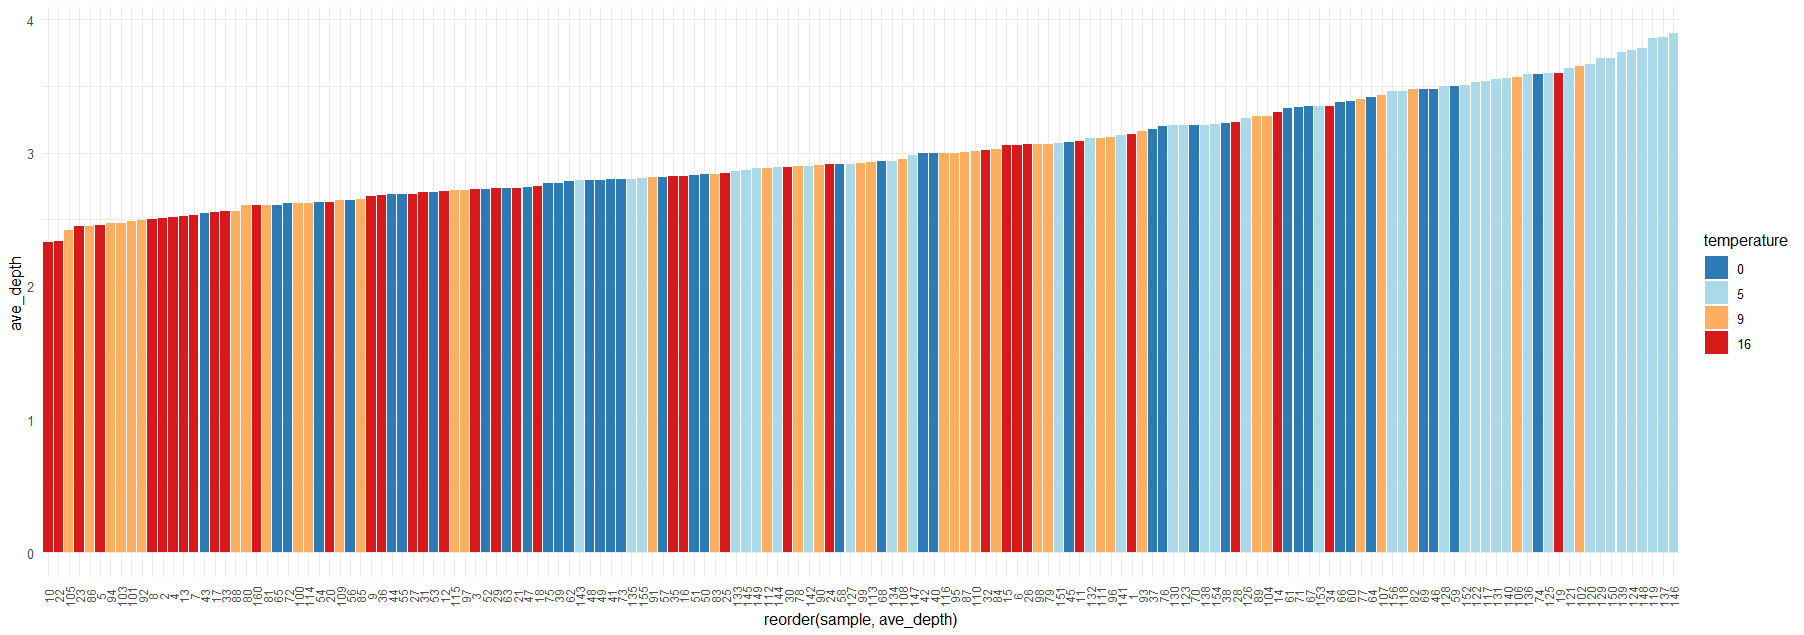

#### Step4: Get Data

Ran the step4-data python script to generate SLURM scripts which calculate genotype likelihoods:

```
(base) [lspencer@node01 analysis-20230828]$ /home/lspencer/lcWGS-pipeline/lcWGSpipeline_step4-data.py -p pcod-lcWGS.ckpt -b blacklist.txt
Step 4 has finished successfully! You will find two new scripts in ./scripts/:
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_globalARRAY.sh calculates genotype likelihoods across all sites on each chromosome (separately).
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_polymorphicARRAY.sh calculates genotype likelihoods across all polymorphic sites on each chromosome (separately).

Both scripts can run simultaneously.
After they have run, you will have genotype likelihoods (gls) and allele frequencies (maf) for all sites in the genome (global) and putatively variable sites (polymorphic).
```

Ran those two SLURM scripts produced by `sbatch scripts/pcod-lcWGS_globalARRAY.sh` and `sbatch scripts/pcod-lcWGS_polymorphicARRAY.sh`. 

#### Step5: Collate

Ran the step5-collate script to generate SLURM scripts to concatenate all the chromosomes and index polymorphic sites across the whole genome:

```
(base) [lspencer@node01 analysis-20230828]$ /home/lspencer/lcWGS-pipeline/lcWGSpipeline_step5-collate.py -p pcod-lcWGS.ckpt
Two new scripts have been generated:

/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_concatenate_beagles.sh concatenates all the polymorphic beagle files to produce a single file containing genotype likelihoods for all polymorphic sites across the genome.

/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_concatenate_mafs.sh concatenates all the polymorphic maf files to produce a single file containing minor allele frequencies for all polymorphic sites across the genome.

Congratulations! Data assembly is complete!
```

Then ran the resulting slurm scripts: `lcWGS_concatenate_beagles.sh` & `sbatch scripts/pcod-lcWGS_concatenate_mafs.sh`

#### Step6: PCA & Admixture analysis

Ran the python code for PCA and admixture: 
```
(base) [lspencer@node04 analysis-20230828]$ /home/lspencer/lcWGS-pipeline/lcWGSpipeline_pca-admixture.py -p pcod-lcWGS.ckpt -k 10
Three scripts have been generated: /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_pcangsdARRAY.sh, /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_wholegenome_pcangsd.sh, and /home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_wholegenome_admixARRAY.sh.
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_pcangsdARRAY.sh will run pca for each chromosome.
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_wholegenome_pcangsd.sh will run pca for the whole genome polymorphic data.
/home/lspencer/pcod-lcwgs-2023/analysis-20230828/scripts/pcod-lcWGS_wholegenome_admixARRAY.sh will launch an array of admixture jobs, testing every value of K between 1 and the max k value entered by the user (three replicates will run for each K value).
All three scripts can run in parallel.
```

#### Generate PCA's in R using the pipelines' resulting covariate matrices 

Using R (script "lcWGS-analysis.Rmd) I ran PCA's on each chromosomal covariate matrix using the function `prcomp()`. Here are [PCA's from all chromosomes, pcas.pdf](https://github.com/laurahspencer/pcod-juveniles-2023/blob/main/lcWGS/analysis-20230823/pca/pcas.pdf). Here is one interesting one (Chr 12) and the whole genome PCA: 

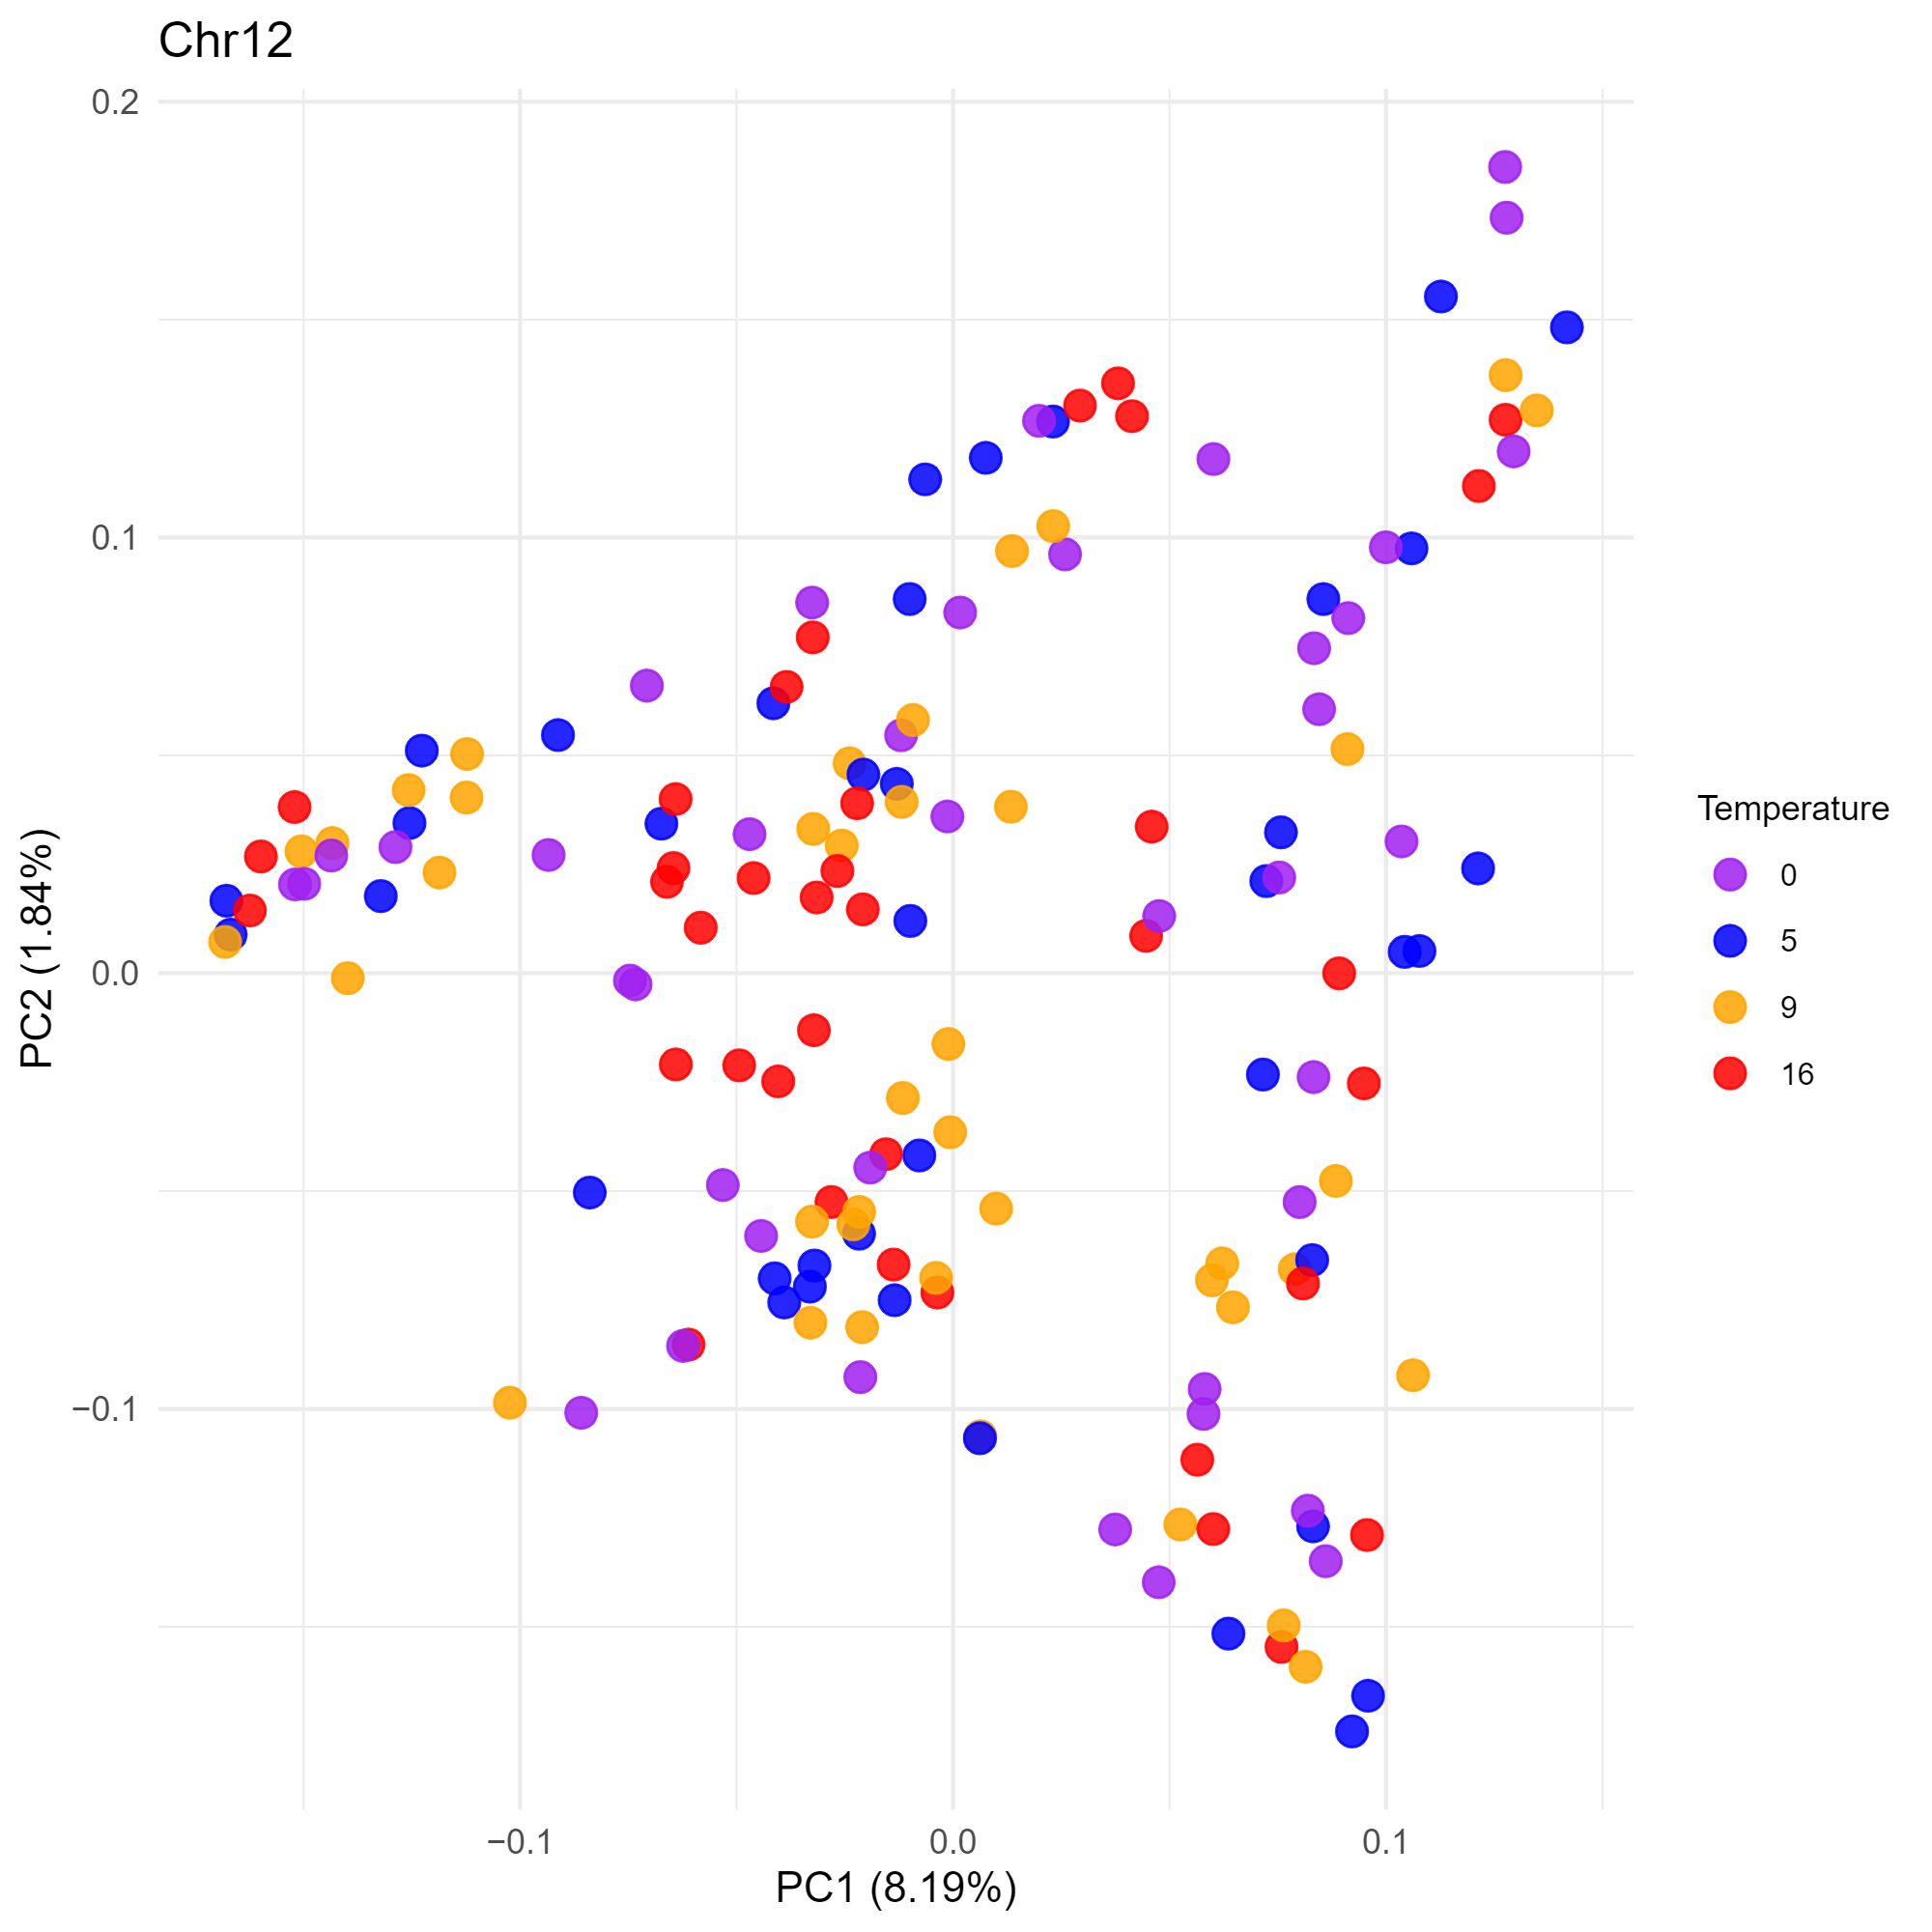

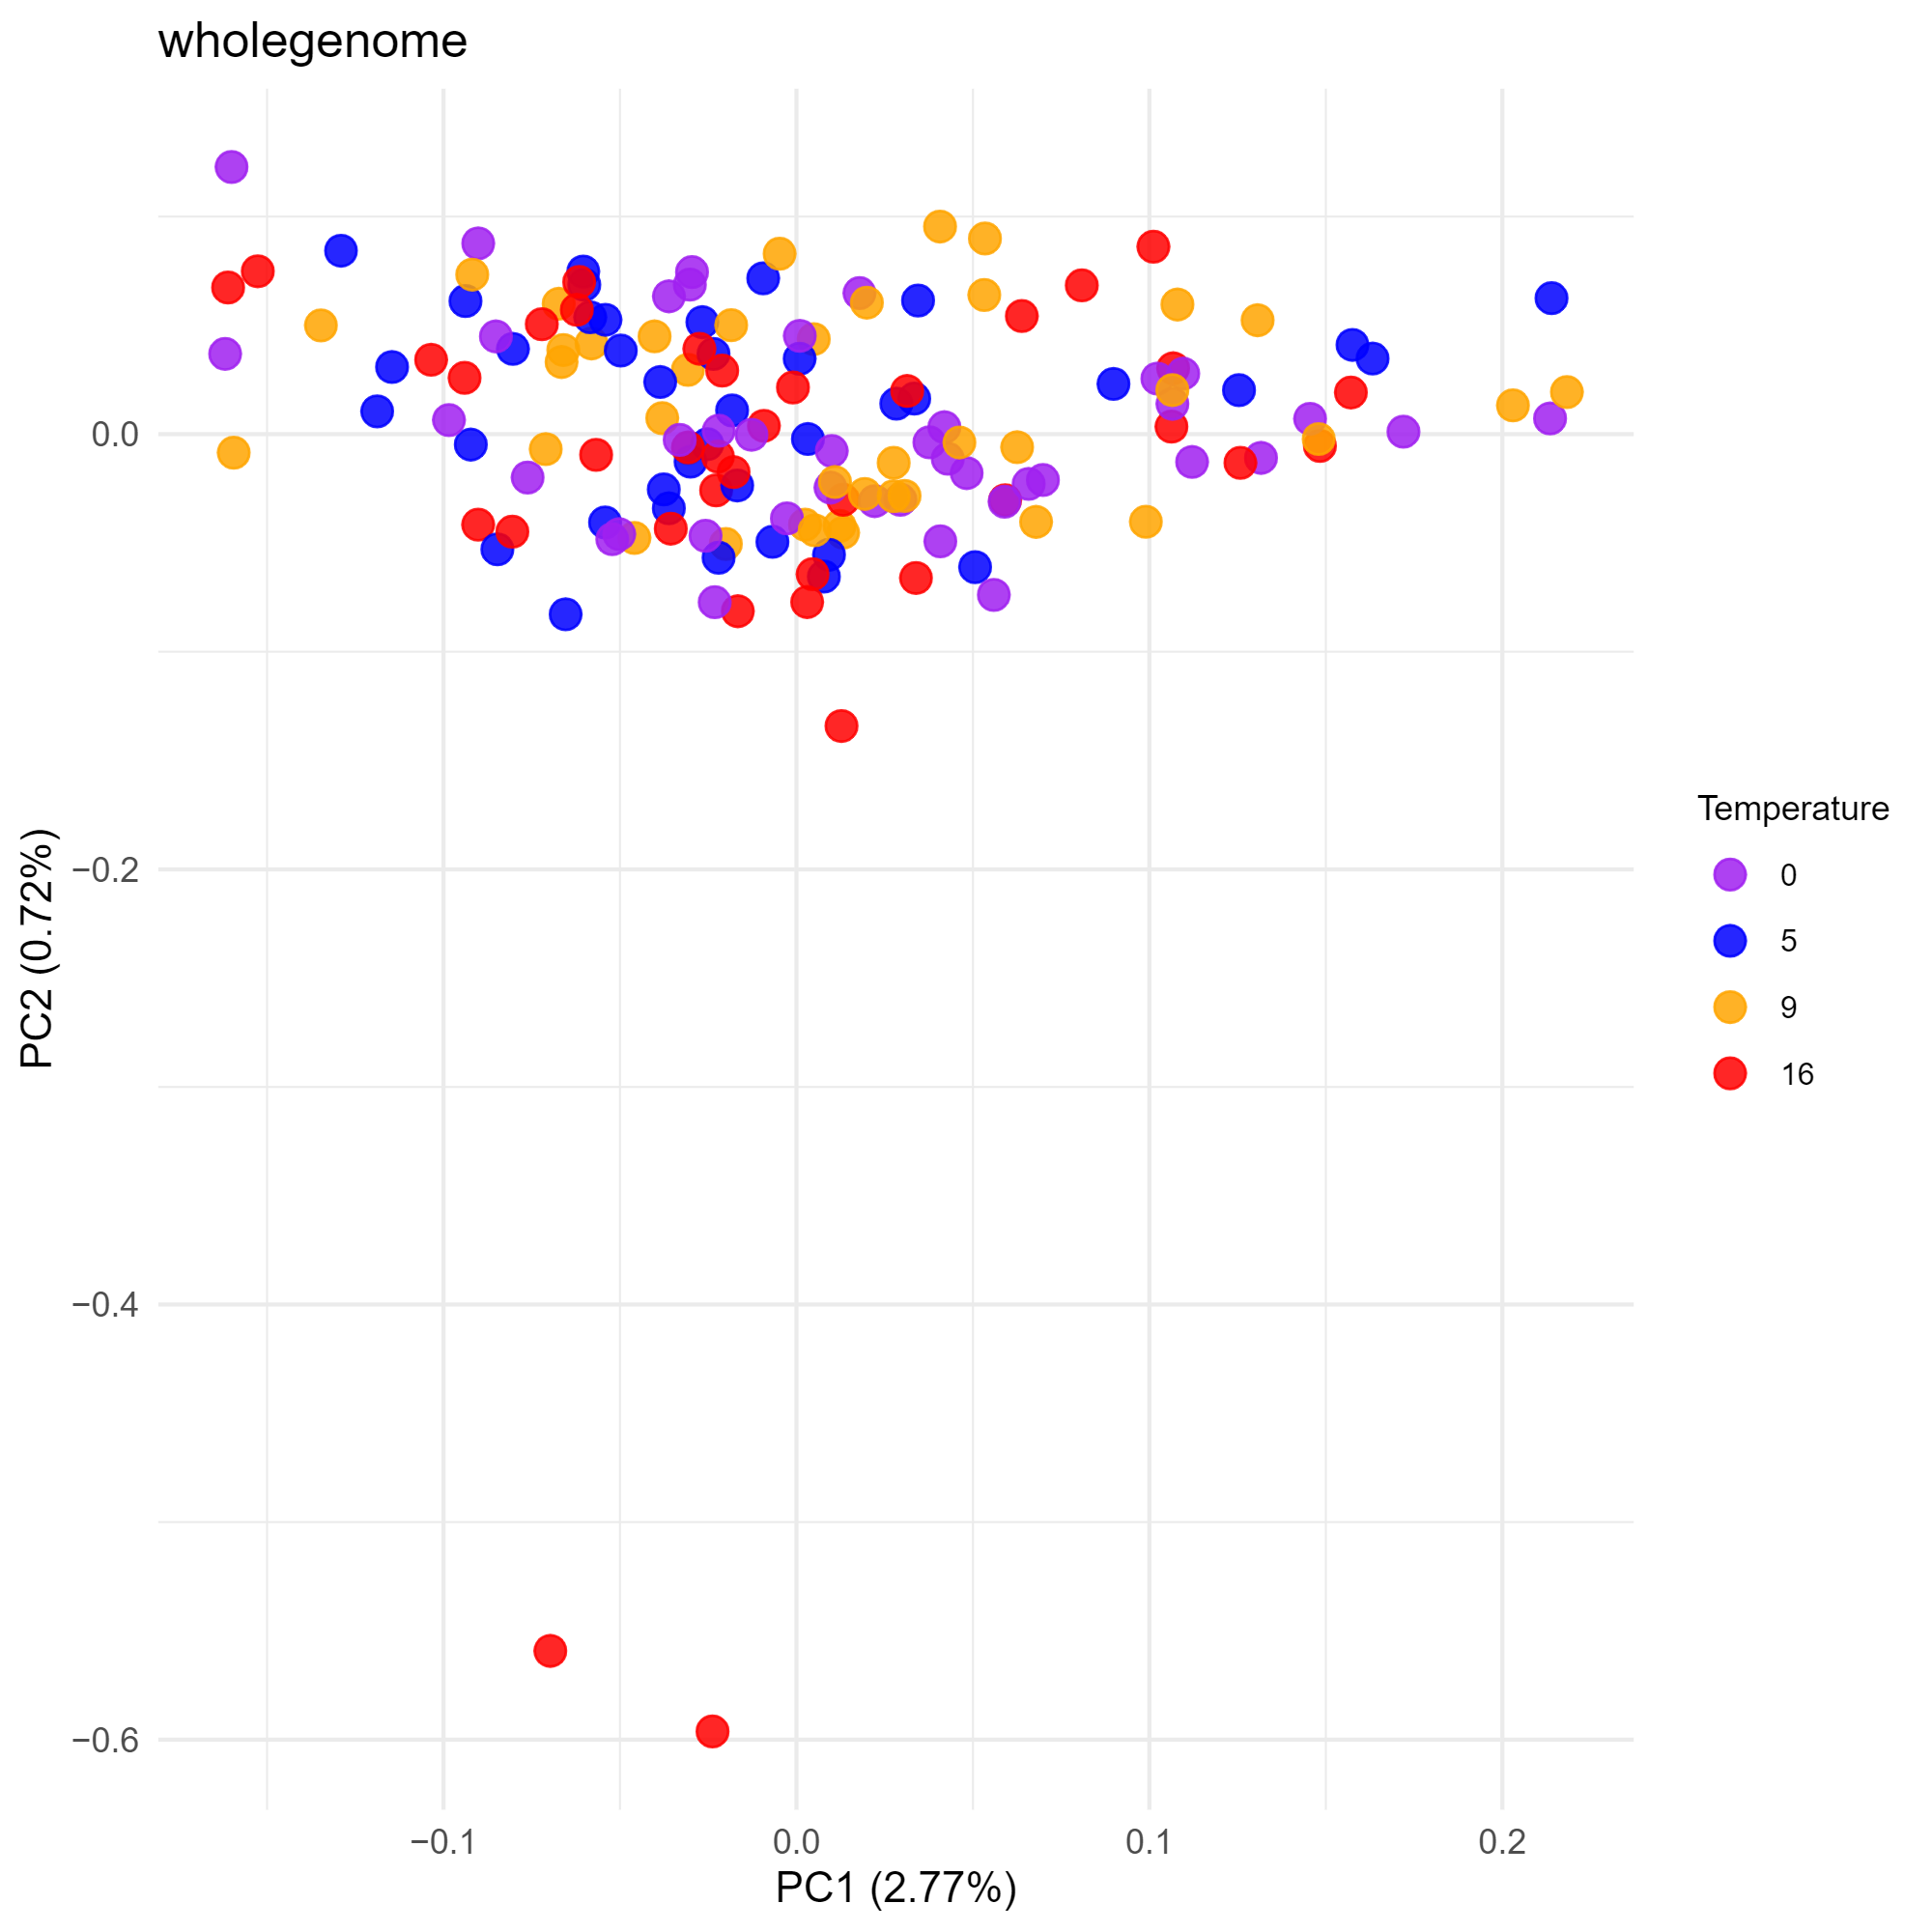

## Re-Analysis including reference fish 

I got the lcWGS pipeline to work using our data! The PCA's indicated no obvious clustering by temperature treatment. BUT we are also very interested in the genetic origin of our wild-caught juveniles. Luckily, Sara Schaal has been characterizing the population structure of P. cod, and has samples with known origin. She had samples from hundreds of fish, so I asked for a subset of those fish for populations of interest. Here's her reply:

_Here are lists of samples from either 5 or 10 individuals from 8 populations in my dataset: Hecate Strait, Kodiak, Shumigans, Unimak, Pervenets Canyon, Amchitka Pass, Tanaga Island, and Russia. The original genomewide pca (pcod20230117_genomewide_pca) is what I used to subset some individuals out for you. I replotted the samples using their pca coordinates from this analysis so you see which ones I chose. I avoided any of those intermediate samples from the Bering Sea and only chose samples from our first sequencing run batch. I gave you a list of 5 and 10 per population because I'm not sure how many samples you'll need to pull out differences. It might be interesting to compare using both to see if it changes your interpretation. PCAs can be finicky depending on what samples and how many are in it... I can run a pca with just those samples using my genotype likelihood file that I have and get back to you with how well the 5 or 10 individuals pull apart those 8 populations. I just probably won't be able to get to that until tomorrow or Wednesday. I also attached a version of the ABLG database that has my edits for the population names included under the "Location1" column._  

So, I reran the lcWGS pipeline with my juvenile P. cod samples AND the subset of samples from known origins. 

### Prepare Inputs 

1. Created new analysis folder on Sedna: /home/lspencer/pcod-lcwgs-2023/analysis-20230922/  
2. **Moved** all my concatenated data files to new analysis folder  
3. Copied over the subset of reference files that Sara provided from Sedna Gold to Sedna: 
  a. Created a list of _all_ reference **filenames** on Sedna Gold using `ls *.fq.gz > /home/laura.spencer/pcod_lcwgs_reference.txt`, then transferred that over to my personal computer using rsync. 
  b. In RStudio, imported the ABLGs_10inds_per_pop.txt file that Sara sent over (which contains **sample ID's** for 10 individuals per population of interest) and the pcod_lcwgs_reference.txt file that I created in step 1. Joined the two files and then saved a new .txt file that contained only the **filenames** for the samples of interest, "pcod_10refs.txt". Moved pcod_10refs.txt over to Sedna in my new analysis folder. 
  c. Used `rsync` to copy over the files of interest (fq.gz) from Sedna Gold to Sedna: `rsync --archive --progress --verbose --files-from=pcod_10refs.txt laura.spencer@161.55.97.203://sednagold/Gadus_macrocephalus/novaseq .` (this code was executed from Sedna).  
  d. Unzipped all the fq.gz files using `gzip -dv *.fq.gz`  

4. Prepared other inputs: Copied chromosomes.txt, adapters.txt, and lcWGS_config.txt from old analysis folder to new analysis folder. 
  a. Modified adapters.txt to include [adapters on reference data](https://github.com/AFSC-Genetics/lcWGS-pipeline/blob/main/NexteraPE-PE.fa) (This was provided by Sara).  
  b. Modifed lcWGS_config.txt with new analysis directory and file names.  
  c. Created new file list via: 
 ```
ls *.{fastq,fq} | while read file; do newfile=`echo /home/lspencer/pcod-lcwgs-2023/analysis-20230922/$file`; echo $newfile >> /home/lspencer/pcod-lcwgs-2023/analysis-20230922/pcod-lcWGS_fastqs.txt; done
 ```
6. Run pipeline! 

Activate virtual environment to access MultiQC: 
`source /home/lspencer/venv/bin/activate`

Define path variables:
`scripts=/home/lspencer/lcWGS-pipeline/`  
`inputs=/home/lspencer/pcod-lcwgs-2023/analysis-20230922/`  

Run first three python scripts: 
```
${scripts}lcWGSpipeline_step0-configure.py -c ${inputs}lcWGS_config.txt
${scripts}lcWGSpipeline_step2-trim.py -p pcod-lcWGS.ckpt
/home/lspencer/lcWGS-pipeline/lcWGSpipeline_step3-align.py -p pcod-lcWGS.ckpt
```
Then initiated the resulting SLURM scripts (so all ran at the same time):
```
sbatch scripts/PGA_assembly_hap2.chrom_only_bwa-indexSLURM.sh
sbatch scripts/PGA_assembly_hap2.chrom_only_faiSLURM.sh
sbatch scripts/pcod-lcWGS-raw_fastqcARRAY.sh
```
When the SLURM jobs were done, ran the multiqc script - `sbatch scripts/pcod-lcWGS-raw_multiqcSLURM.sh` - After it finished I transferred the multiqc files to my local computer to view and renamed to "_raw". There's definitely differences among the data from our experimental animals and the reference data. 

I then ran these scripts, one after the other, to trim and then look at the trimmed data:
```
sbatch scripts/pcod-lcWGS_trimARRAY.sh  
sbatch scripts/pcod-lcWGS-trim_fastqcARRAY.sh  
sbatch scripts/pcod-lcWGS-trim_multiqcSLURM.sh  
```

Transferred the multiqc html file to my local computer, renamed to "_trimmed". Looks good!

Ran the alignment scripts one after the other:  
`sbatch pcod-lcWGS_alignARRAY.sh`  
`sbatch scripts/pcod-lcWGS_depthsARRAY.sh` - I had to modify this script to include the full path for the python script  `/home/lspencer/lcWGS-pipeline/mean_cov_ind.py.`  

This barplot shows the mean coverage depth for each sample (sorted by depth), color coded by temperature treatment or sample location. The lcWGS pipeline states that samples with mean depth <1 should be blacklisted. All samples look good! 

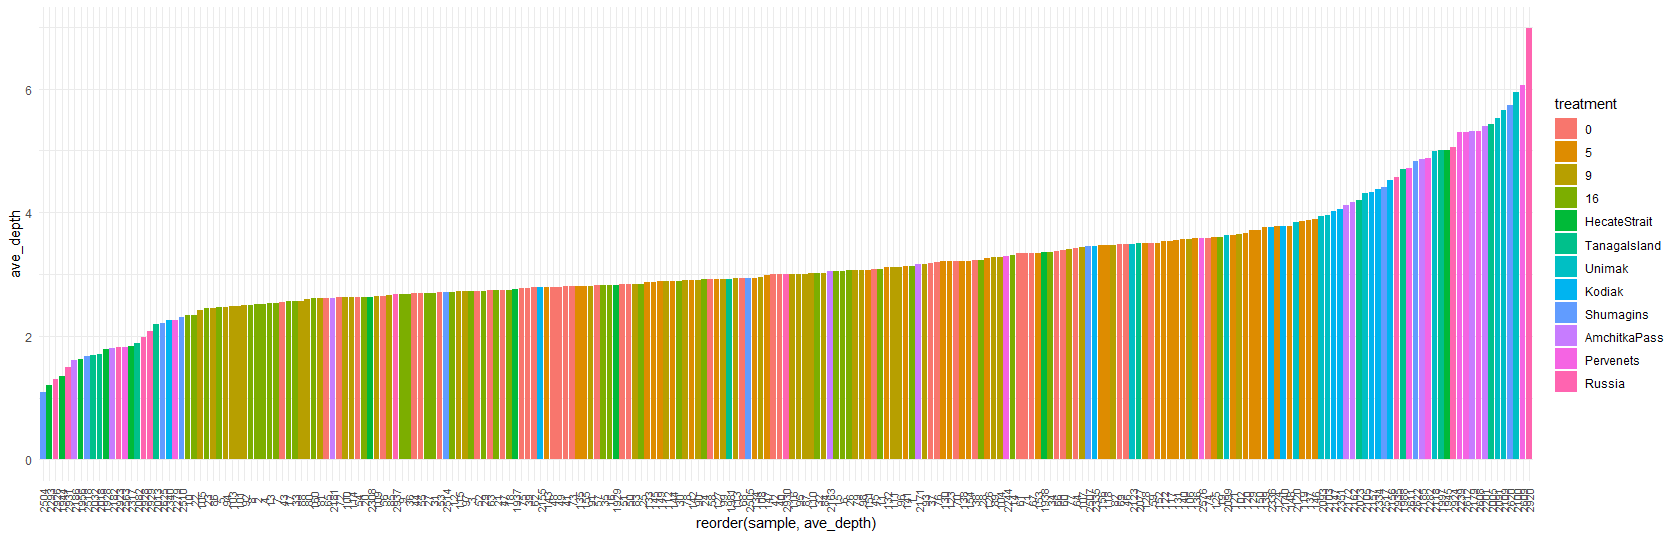

Copied the empty blacklist over to the new analysis director, and ran `/home/lspencer/lcWGS-pipeline/lcWGSpipeline_step4-data.py -p pcod-lcWGS.ckpt -b blacklist.txt`, then ran those two SLURM scripts: `sbatch scripts/pcod-lcWGS_globalARRAY.sh` and `sbatch scripts/pcod-lcWGS_polymorphicARRAY.sh`

Ran the collate script: `/home/lspencer/lcWGS-pipeline/lcWGSpipeline_step5-collate.py -p pcod-lcWGS.ckpt`  
Then ran the resulting slurm scripts: `sbatch scripts/pcod-lcWGS_concatenate_beagles.sh` & `sbatch scripts/pcod-lcWGS_concatenate_mafs.sh`

Ran the PCA/Admixture python script: `/home/lspencer/lcWGS-pipeline/lcWGSpipeline_pca-admixture.py -p pcod-lcWGS.ckpt -k 10` then the three resulting scripts in parallel: `pcod-lcWGS_pcangsdARRAY.sh`, `pcod-lcWGS_wholegenome_pcangsd.sh`, and `pcod-lcWGS_wholegenome_admixARRAY.sh`

RESUTS

Performed PCA in R. Ran into a couple issues. First, the number of samples in the resulting covariance matrices doesn't match the total number of samples in the analysis. I believe I ran an old script somewhere in the pipeline (probably a script from the run that didn't include reference fish). Additionally, there is no population clustering in my PCA. So, I'm going to re-run the analysis using ALL reference fish. Sara Schaal said that the PCAs can be sensitive to subsetting populations, etc, so better safe than an error-prone analysis. 

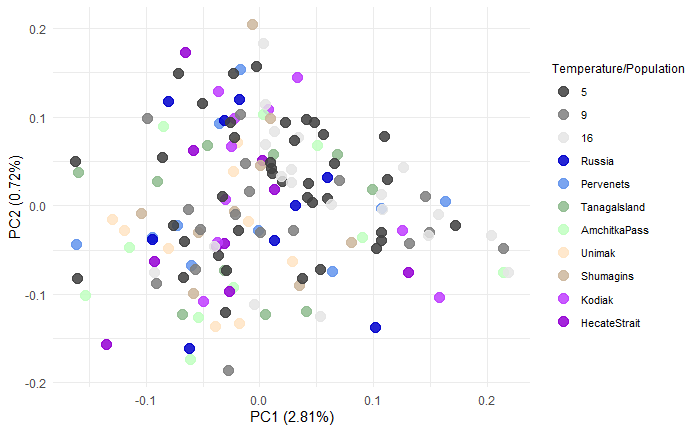

## Re-Analysis with ALL reference fish 

I created a new analysis directory (analysis20231002) and moved the following files there from the 20230922/ directory: 
- adapters.txt  
- blacklist.txt  
- chromosomes.txt  
- lcWGS_config.txt  
- all the .fq and .fastq files  

I then transferred all the other reference fish data to the new directory: 

```
cd /home/lspencer/pcod-lcWGS/analysis20231002/
rsync --archive --progress --verbose laura.spencer@161.55.97.203://sednagold/Gadus_macrocephalus/novaseq .
```

